In [1]:
import time
import itertools
import os
import re
import json
import pickle
from tqdm.notebook import tqdm

import numpy as np
import scipy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gensim
import spacy
# для подсвечивания слов
from ipymarkup import show_box_markup

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
colors = np.array(['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black', 
                   'limegreen'])

In [4]:
from sklearn.datasets import fetch_20newsgroups

In [5]:
data = fetch_20newsgroups()['data']
target = np.array(fetch_20newsgroups()['target_names'])[fetch_20newsgroups()['target']]

In [6]:
# Remove Emails
processed_data = [re.sub('\S*@\S*\s?', '', sent) for sent in tqdm(data)]

# Remove new line characters
processed_data = [re.sub('\s+', ' ', sent) for sent in tqdm(data)]

# Remove distracting single quotes
processed_data = [re.sub("\'", "", sent) for sent in tqdm(data)]

# Убираем заголовки письма:
processed_data2 = []
for text in tqdm(processed_data):
    for val in re.findall(r'\w+:.+\n', text):
        if 'subject' not in val:
            text = text.replace(val, '')
    processed_data2.append(text)

In [7]:
k = np.random.randint(0, len(data))
print('k:', k)
print('target:', target[k], '\n'*2)
print('text' + '-'*50 + '\n')
print(data[k])
print('processed_text' + '-'*80 + '\n')
print(processed_data[k])
print('-'*80)

k: 369
target: talk.politics.misc 


text--------------------------------------------------

From: riggs@descartes.etl.army.mil (Bill Riggs)
Subject: Re: hard times investments was: (no subject given)
Organization: LNK Corporation, Riverdale, MD
Lines: 50
Nntp-Posting-Host: descartes.tec.army.mil

In article <1pkvcl$nu0@usenet.INS.CWRU.Edu> an030@cleveland.Freenet.Edu (Broward Horne) writes:
>
>In a previous article, riggs@descartes.etl.army.mil (Bill Riggs) says:
>
>>so much land, and in the long run, we have a zero sum game going. Someone,
>>somewhere, is going to make a killing from nosediving real estate
>>markets. The worst thing to do is panic. The best thing you can do is
>>to ride out deflation to the end. It hurts, but you're better off 
>>than if you sell short and donate to someone else's inheritance.
>
>
>      Sad.  Paradigm Shift is coming, chum.
>     Ride the WAVE!

	I don't believe in the "Wave Theory".

>
>     " There's only so much land ".   Oh, God, is this Mike Zi

In [139]:
# Лемматизация и удаление стоп-слов:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'be', 'the', 'is', '-PRON-', 'would', 
                  'one', 'get', 'like', 'know', 'make', 'say', 'think', 'go'])
stop_words = set(stop_words)

nlp = spacy.load('en', disable=['parser', 'ner'])

texts = []
for text in tqdm(processed_data2):
    sentence = ' '.join(gensim.utils.simple_preprocess(text, deacc=True))
    texts.append([word.lemma_ for word in nlp(sentence) if word.lemma_ not in stop_words])


In [163]:
' '.join(texts[0])

'nntp posting wonder anyone could enlighten car see day door sport car look late early call bricklin door really small addition front bumper separate rest body anyone tellme model name engine spec year production car history whatever info funky look car please mail thank il bring neighborhood lerxst'

In [140]:
%%time
json.dump(texts, open('/Users/tony/Desktop/.processed_20newsgroups.json', mode='w', 
                      encoding='utf-8'), ensure_ascii=False, indent=2);

CPU times: user 1.22 s, sys: 66.6 ms, total: 1.29 s
Wall time: 1.51 s


In [141]:
%%time
texts = json.load(open('/Users/tony/Desktop/.processed_20newsgroups.json', mode='r', encoding='utf-8'))

CPU times: user 672 ms, sys: 242 ms, total: 914 ms
Wall time: 1.47 s


In [142]:
from gensim import corpora

In [143]:
# Create Dictionary
id2word = corpora.Dictionary(texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [144]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

CPU times: user 7min 31s, sys: 38.5 s, total: 8min 9s
Wall time: 4min 50s


In [145]:
# pickle.dump(lda_model, open('/Users/tony/Desktop/lda_model.pkl', mode='wb'))
lda_model_new = pickle.load(open('/Users/tony/Desktop/lda_model.pkl', mode='rb'))

In [166]:
lda_model.print_topics()

[(0,
  '0.045*"israel" + 0.019*"war" + 0.019*"soldier" + 0.018*"village" + 0.015*"turkish" + 0.014*"jews" + 0.013*"attack" + 0.013*"president" + 0.012*"kill" + 0.012*"occupy"'),
 (1,
  '0.044*"god" + 0.024*"evidence" + 0.021*"believe" + 0.019*"reason" + 0.015*"claim" + 0.014*"sense" + 0.013*"talk" + 0.012*"exist" + 0.012*"faith" + 0.011*"christian"'),
 (2,
  '0.015*"program" + 0.013*"thank" + 0.013*"mail" + 0.012*"file" + 0.012*"information" + 0.011*"include" + 0.011*"send" + 0.010*"please" + 0.010*"number" + 0.009*"available"'),
 (3,
  '0.046*"team" + 0.043*"game" + 0.034*"win" + 0.032*"play" + 0.027*"year" + 0.016*"season" + 0.015*"vs" + 0.014*"division" + 0.014*"wing" + 0.014*"fan"'),
 (4,
  '0.076*"window" + 0.040*"entry" + 0.034*"master" + 0.033*"video" + 0.031*"graphic" + 0.024*"driver" + 0.023*"dos" + 0.023*"monitor" + 0.023*"st" + 0.022*"screen"'),
 (5,
  '0.081*"patient" + 0.053*"health" + 0.048*"disease" + 0.042*"eat" + 0.041*"medical" + 0.033*"treatment" + 0.030*"wa" + 0.030

In [146]:
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()

In [88]:
# %%time
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word) 
# pyLDAvis.display(vis)

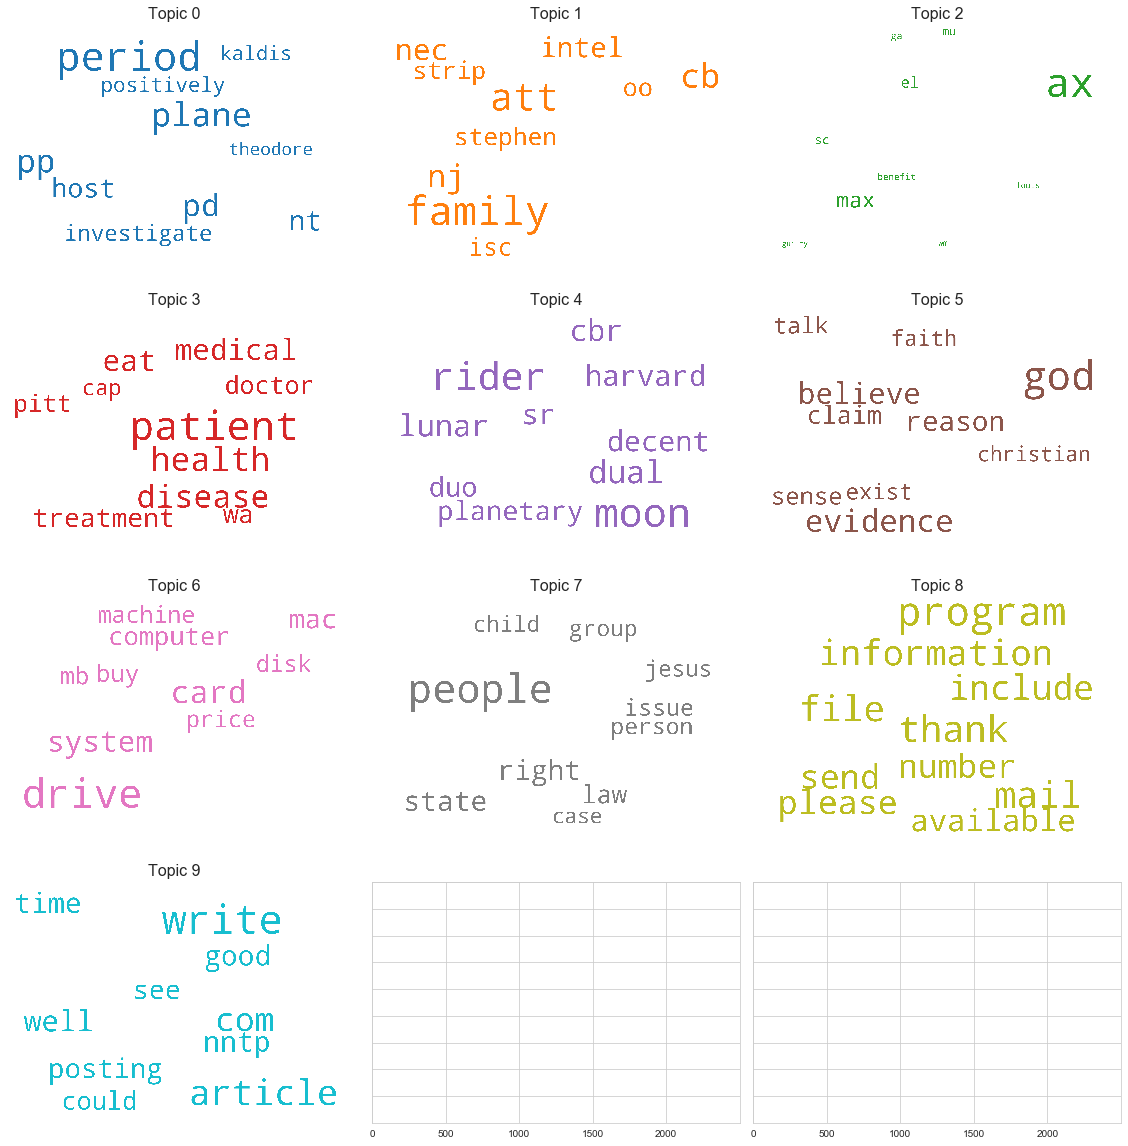

In [147]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_topics=10)

fig, axes = plt.subplots(4, 3, figsize=(16,16), sharex=True, sharey=True)

for i, ax in tqdm(enumerate(axes.flatten())):
    if i == len(topics):
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout(h_pad=3)
plt.show()

In [ ]:
texts[]

In [156]:
sorted(lda_model.get_document_topics(bow=corpus[k]), key=lambda x: x[1], reverse=True)

[(12, 0.42729393),
 (16, 0.17145674),
 (15, 0.1534017),
 (2, 0.066259116),
 (13, 0.05183703),
 (9, 0.030444775),
 (18, 0.024641315),
 (3, 0.020825053),
 (8, 0.01295573),
 (0, 0.011631264),
 (5, 0.0105843)]

In [172]:
lda_model.print_topics()[15]

(15,
 '0.035*"drive" + 0.020*"card" + 0.018*"system" + 0.015*"mac" + 0.013*"computer" + 0.012*"mb" + 0.011*"buy" + 0.011*"machine" + 0.011*"price" + 0.011*"disk"')

In [150]:
target[k]

'sci.space'

In [155]:
k = np.random.randint(len(texts))
' '.join(texts[k])

'reply rec auto boyle cactus org craig boyle write xin article qgi einnhs skeena ucs ubc ca yiklam unixg ubc ca yik chong lam write hello anyone take bolt engine compartment turn clockwise counter try kind lubricant wd etc still fail electric drill change suitable bit turn succeed tighten tight safe without oil leak xassuming russian car opposite thread xyou turn professional xhelp may locate draing plug xactually try loosen something else xcraig thank much advance winson remind first time cousin oil change car crawl remove bolt drain fluid replace bolt carefully pour quart oil bother check dip stick drive far till find drain speed tran dump extra quart engine person help first time mack costello mcostell oasys dt navy mil code formerly david taylor model basin carderock division hq nswc bethesda md phone'

In [168]:
print(data[k])

From: mcostell@oasys.dt.navy.mil (Malcolm G. Costello)
Subject: Re: Changing oil by self.
Reply-To: mcostell@oasys.dt.navy.mil (Malcolm G. Costello)
Distribution: usa
Organization: Carderock Division, NSWC, Bethesda, MD
Lines: 35

In rec.autos, boyle@cactus.org (Craig Boyle) writes:
xIn article <1qgi8eINNhs5@skeena.ucs.ubc.ca> yiklam@unixg.ubc.ca (Yik Chong Lam)
x writes:
x>Hello,
x>
x>       Does anyone know how to take out the bolt under the engine
x>compartment?  Should I turn clockwise or counter?  I tried any kind
x>of lubricants, WD-40,etc, but I still failed!
x>       Do you think I can use a electric drill( change to a suitable
x>bit ) to turn it out?  If I can succeed, can I re-tighten it not too
x>tight, is it safe without oil leak?
x
xAssuming you don't have a Russian car with opposite threads, then
xyou turn counterclockwise. I would get some professional
xhelp here, you may not have located the draing plug and
xactually be trying to loosen something else.
x
xCraig
x>
x>
x>

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_topics=10)

fig, axes = plt.subplots(4, 3, figsize=(16,16), sharex=True, sharey=True)

for i, ax in tqdm(enumerate(axes.flatten())):
    if i == len(topics):
        break
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout(h_pad=3)
plt.show()